In [7]:
# OBJETIVO: Unificar datos crudos, eliminar duplicados, analizar distribución y generar split final.

# Instalar librerías necesarias
# !pip install imagehash tqdm seaborn matplotlib scikit-learn
# Importar librerías
import os
import glob
import shutil
import hashlib
import imagehash
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import yaml
import numpy as np

# --- CONFIGURACIÓN DE RUTAS ---
# Origen: Donde descargamos los datos de Kaggle
SOURCE_PATH = '../../data/processed/01_autos_original' 

# Destino: Donde YOLO buscará los datos para entrenar
DEST_PATH = '../../datasets/01_autos'

# Semilla para reproducibilidad
RANDOM_SEED = 42

print("Listo")

Listo


In [2]:
def inventory_files(root_path):
    """Recorre todas las subcarpetas y empareja imágenes con sus labels."""
    data_pairs = []
    
    # Buscamos en todas las subcarpetas (train, val, test originales)
    # Extensiones posibles de imagen
    img_patterns = ['*.jpg', '*.jpeg', '*.png']
    
    all_images = []
    for pattern in img_patterns:
        # Recursive search
        all_images.extend(glob.glob(os.path.join(root_path, '**', pattern), recursive=True))
    
    print(f"🔍 Escaneando {len(all_images)} imágenes potenciales...")
    
    for img_path in tqdm(all_images):
        # Inferir ruta del label (mismo nombre, extensión .txt)
        # La estructura original suele tener carpetas 'images' y 'labels' paralelas o juntas.
        # Asumiremos que están juntas o en estructura standard.
        
        base_dir = os.path.dirname(img_path)
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        
        
        lbl_path = os.path.join(base_dir, f"{base_name}.txt")
        if not os.path.exists(lbl_path) and base_dir.endswith('images'):
            lbl_dir = base_dir.replace('images', 'labels')
            lbl_path = os.path.join(lbl_dir, f"{base_name}.txt")
            
        if os.path.exists(lbl_path):
            data_pairs.append({'image': img_path, 'label': lbl_path, 'id': base_name})
            
    return pd.DataFrame(data_pairs)

# Ejecutar inventario
df_inventory = inventory_files(SOURCE_PATH)
print(f"Completado. Pares válidos encontrados: {len(df_inventory)}")
df_inventory.head()

🔍 Escaneando 16185 imágenes potenciales...


  0%|          | 0/16185 [00:00<?, ?it/s]

Completado. Pares válidos encontrados: 16185


,image,label,id
0,../../data/processed/01_autos_original/test/im...,../../data/processed/01_autos_original/test/la...,012267
1,../../data/processed/01_autos_original/test/im...,../../data/processed/01_autos_original/test/la...,009807
2,../../data/processed/01_autos_original/test/im...,../../data/processed/01_autos_original/test/la...,008269
3,../../data/processed/01_autos_original/test/im...,../../data/processed/01_autos_original/test/la...,003372
4,../../data/processed/01_autos_original/test/im...,../../data/processed/01_autos_original/test/la...,011269


Generando Perceptual Hashing...


  0%|          | 0/16185 [00:00<?, ?it/s]

\Reporte:
   - Imágenes totales: 16185
   - Duplicados: 43
   - Integridad del Dataset: 99.73%
\Mostrando 5 de 43 casos:


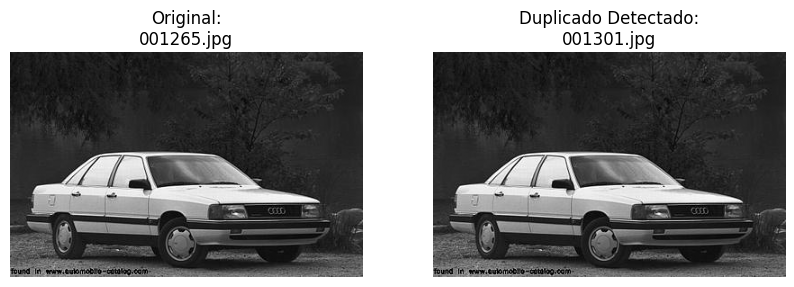

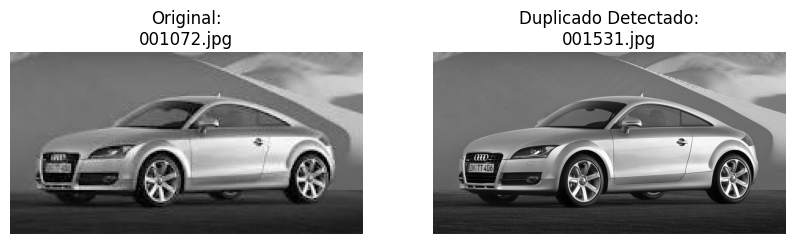

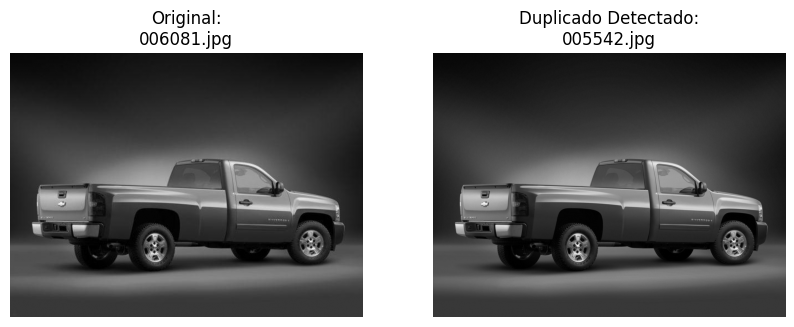

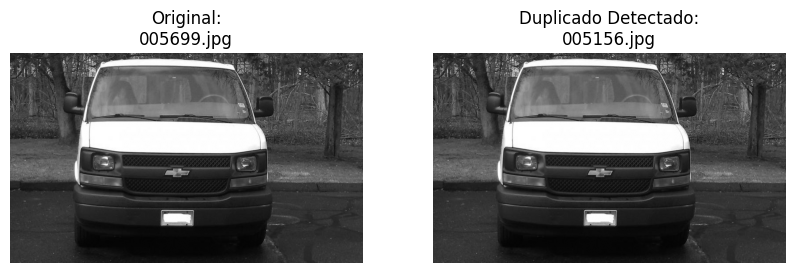

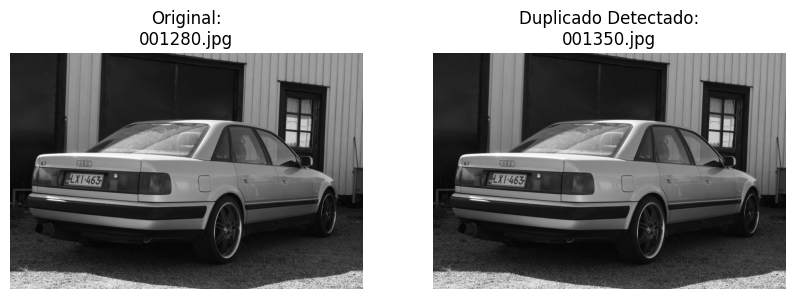

Se ha guardado un reporte detallado en 'data/processed/01_autos_reporte_duplicados.csv'

Dataset Final Limpio: 16142 imágenes únicas listas para EDA.


In [4]:
# --- CELDA 3: Detección y Análisis Visual de Duplicados ---

def analyze_duplicates(df, hash_size=16):
    """
    Calcula hashes y devuelve:
    1. Una lista de índices para borrar (dupe_indices).
    2. Una lista de tuplas con las rutas (original, duplicado) para inspección visual.
    """
    print("Generando Perceptual Hashing...")
    
    hashes = {}          # Diccionario: {hash: ruta_imagen_original}
    indices_to_drop = [] # Lista de índices para eliminar
    duplicate_pairs = [] # Lista de tuplas: (ruta_original, ruta_duplicada)
    
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        try:
            with Image.open(row['image']) as img:
                # Calculamos el hash
                h = str(imagehash.average_hash(img, hash_size=hash_size))
                
                if h in hashes:
                    # Duplicado
                    original_path = hashes[h]
                    current_path = row['image']
                    
                    # Guardar la evidencia
                    duplicate_pairs.append((original_path, current_path))
                    
                    # Marcar el actual para borrar
                    indices_to_drop.append(idx)
                else:
                    # No duplicado
                    hashes[h] = row['image']
                    
        except Exception as e:
            print(f"Error leyendo imagen {row['image']}: {e}")
            indices_to_drop.append(idx) # Si hay error, borrar imagen
            
    return indices_to_drop, duplicate_pairs

def visualize_duplicates(pairs, limit=5):
    """Muestra lado a lado el original vs el duplicado detectado."""
    if not pairs:
        print("Sin duplicados.")
        return

    print(f"\Mostrando {min(len(pairs), limit)} de {len(pairs)} casos:")
    
    for i, (orig, dupe) in enumerate(pairs[:limit]):
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        
        # Imagen Original (la primera que encontró)
        img1 = Image.open(orig)
        axes[0].imshow(img1, cmap='gray')
        axes[0].set_title(f"Original:\n{os.path.basename(orig)}")
        axes[0].axis('off')
        
        # Imagen Duplicada (la que se va a borrar)
        img2 = Image.open(dupe)
        axes[1].imshow(img2, cmap='gray')
        axes[1].set_title(f"Duplicado Detectado:\n{os.path.basename(dupe)}")
        axes[1].axis('off')
        
        plt.show()

# --- EJECUCIÓN ---

# 1. Detectar
dupe_indices, dupe_evidence = analyze_duplicates(df_inventory)

# 2. Reporte
print(f"\Reporte:")
print(f"   - Imágenes totales: {len(df_inventory)}")
print(f"   - Duplicados: {len(dupe_indices)}")
print(f"   - Integridad del Dataset: {100 - (len(dupe_indices)/len(df_inventory)*100):.2f}%")

# 3. Visualizar
visualize_duplicates(dupe_evidence, limit=5)

# 4. Guardar Log en un CSV con la evidencia de qué archivos se borraron
if dupe_evidence:
    df_dupes = pd.DataFrame(dupe_evidence, columns=['Original_Conservado', 'Duplicado_Eliminado'])
    df_dupes.to_csv('../../data/processed/01_autos_reporte_duplicados.csv', index=False)
    print("Se ha guardado un reporte detallado en 'data/processed/01_autos_reporte_duplicados.csv'")

# 5. Limpiar el DataFrame
df_clean = df_inventory.drop(dupe_indices).reset_index(drop=True)
print(f"\nDataset Final Limpio: {len(df_clean)} imágenes únicas listas para EDA.")

  0%|          | 0/16142 [00:00<?, ?it/s]

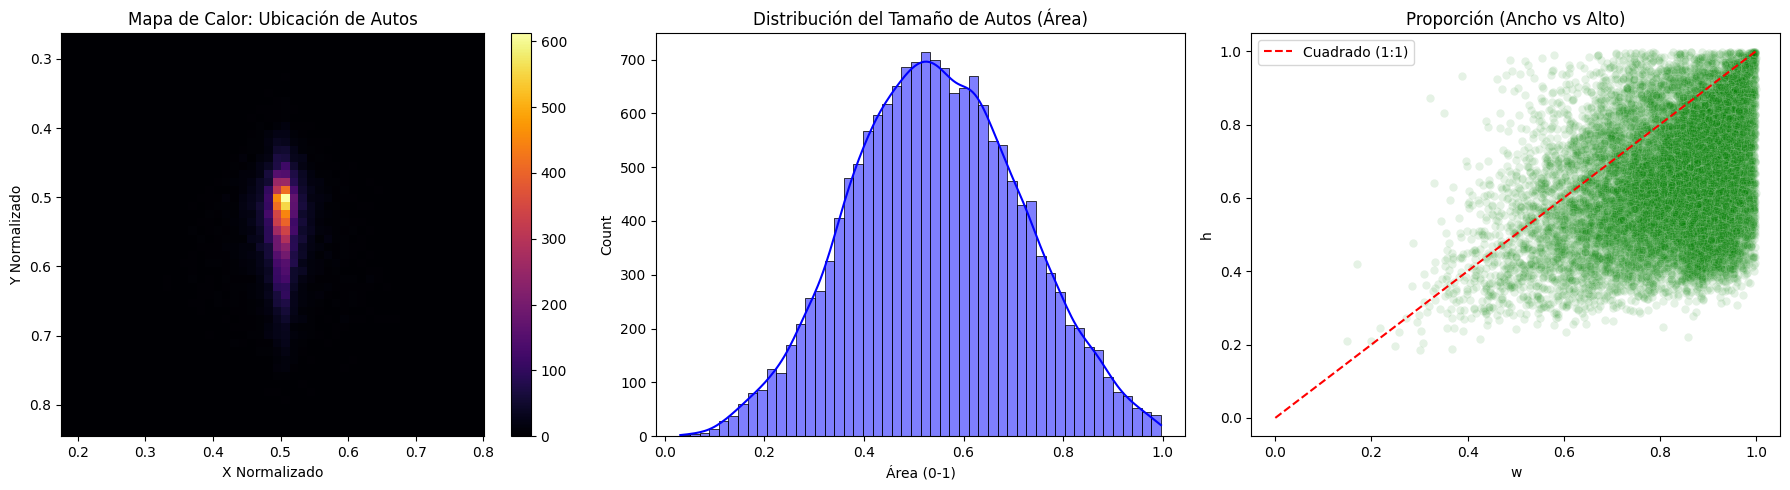

Imágenes generadas.


In [5]:
# Función para leer las coordenadas normalizadas de los txt
def parse_labels(df):
    all_boxes = []
    
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        with open(row['label'], 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:
                    # class x_center y_center width height
                    cls = int(parts[0])
                    x = float(parts[1])
                    y = float(parts[2])
                    w = float(parts[3])
                    h = float(parts[4])
                    all_boxes.append([cls, x, y, w, h])
                    
    return pd.DataFrame(all_boxes, columns=['class', 'x', 'y', 'w', 'h'])

df_boxes = parse_labels(df_clean)

# --- GRÁFICAS ---
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# 1. Mapa de Calor de Posiciones
h = axs[0].hist2d(df_boxes['x'], df_boxes['y'], bins=50, cmap='inferno')
axs[0].set_title('Mapa de Calor: Ubicación de Autos')
axs[0].set_xlabel('X Normalizado')
axs[0].set_ylabel('Y Normalizado')
axs[0].invert_yaxis()
fig.colorbar(h[3], ax=axs[0])

# 2. Distribución de Tamaños (Area)
df_boxes['area'] = df_boxes['w'] * df_boxes['h']
sns.histplot(df_boxes['area'], bins=50, kde=True, ax=axs[1], color='blue')
axs[1].set_title('Distribución del Tamaño de Autos (Área)')
axs[1].set_xlabel('Área (0-1)')

# 3. Relación de Aspecto
sns.scatterplot(data=df_boxes, x='w', y='h', alpha=0.1, ax=axs[2], color='green')
axs[2].plot([0,1], [0,1], 'r--', label='Cuadrado (1:1)')
axs[2].set_title('Proporción (Ancho vs Alto)')
axs[2].legend()

plt.tight_layout()
plt.show()

print("Imágenes generadas.")

Calculando áreas de objetos para estratificación...


  0%|          | 0/16142 [00:00<?, ?it/s]

Reporte: 0 imágenes vacías (Background) y 0 errores de lectura.


/tmp/ipykernel_6225/2709247209.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stratify_group', data=df_clean, palette='coolwarm')


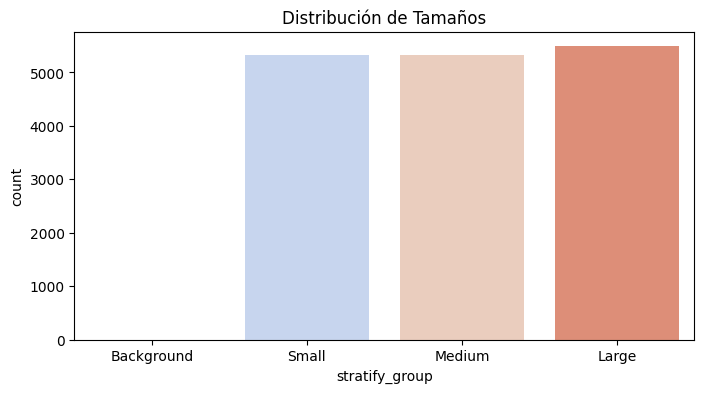

In [9]:
def add_stratification_metadata(df):
    print("Calculando áreas de objetos para estratificación...")
    areas = []
    
    # Verifica si se llama 'label' (Autos) o 'label_path' (Placas)
    col_name = 'label' if 'label' in df.columns else 'label_path'
    
    empty_count = 0
    error_count = 0
    
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        try:
            txt_path = row[col_name]
            
            with open(txt_path, 'r') as f:
                lines = f.readlines()
            
            img_areas = []
            for line in lines:
                parts = list(map(float, line.strip().split()))
                # Formato YOLO: class x y w h (w=índice 3, h=índice 4)
                if len(parts) >= 5:
                    w, h = parts[3], parts[4]
                    img_areas.append(w * h) 
            
            if img_areas:
                # Promedio del tamaño de autos en la foto
                avg_area = sum(img_areas) / len(img_areas)
                areas.append(avg_area)
            else:
                # Archivo existe pero está vacío o sin formato válido
                areas.append(0.0)
                empty_count += 1
                
        except Exception as e:
            # Si falla la lectura, imprimimos el primer error y paramos para no llenar la consola
            if error_count == 0:
                print(f"Error leyendo el archivo:  {txt_path}: {e}")
            areas.append(0.0)
            error_count += 1

    df['bbox_area'] = areas
    
    print(f"Reporte: {empty_count} imágenes vacías (Background) y {error_count} errores de lectura.")

    # Crear Binning (Categorías)
    # Filtramos solo los que tienen área > 0 para calcular los cuartiles
    autos_existentes = df[df['bbox_area'] > 0]
    
    if len(autos_existentes) > 0:
        # Dividimos en 3 grupos (Small, Medium, Large) basados en percentiles 33% y 66%
        # Esto asegura que haya la misma cantidad de "Small" que de "Large"
        p33 = np.percentile(autos_existentes['bbox_area'], 33)
        p66 = np.percentile(autos_existentes['bbox_area'], 66)
        
        # Definimos los cortes: [-1, 0, p33, p66, 1.0]
        # Bins: 
        #   -1 a 0    -> Background
        #    0 a p33  -> Small
        #  p33 a p66  -> Medium
        #  p66 a 1.0  -> Large
        bins = [-1.0, 0.000001, p33, p66, 10.0] 
        labels = ['Background', 'Small', 'Medium', 'Large']
        
        df['stratify_group'] = pd.cut(df['bbox_area'], bins=bins, labels=labels, include_lowest=True)
    else:
        print("⚠️ ALERTA: No se detectaron áreas válidas. Revisa si los TXT tienen contenido.")
        df['stratify_group'] = 'Unknown'
        
    return df

# Aplicar corrección
df_clean = add_stratification_metadata(df_clean)

# Visualizar de nuevo
plt.figure(figsize=(8,4))
sns.countplot(x='stratify_group', data=df_clean, palette='coolwarm')
plt.title('Distribución de Tamaños')
plt.show()

In [13]:
def filter_blurry_images(df, threshold=100.0):
    print("📷 Analizando nitidez (Blur Detection)...")
    sharpness_scores = []
    
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        img = cv2.imread(row['image_path'])
        if img is None: 
            sharpness_scores.append(0.0)
            continue
            
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # La varianza del Laplaciano es un método estándar para medir el enfoque
        score = cv2.Laplacian(gray, cv2.CV_64F).var()
        sharpness_scores.append(score)
        
    df['sharpness'] = sharpness_scores
    
    # Filtrar
    initial_len = len(df)
    df_sharp = df[df['sharpness'] > threshold].reset_index(drop=True)
    print(f"📉 Eliminadas {initial_len - len(df_sharp)} imágenes borrosas (Score < {threshold})")
    
    return df_sharp


In [15]:
# Split ESTRATIFICADO 
train_df, temp_df = train_test_split(
    df_clean, 
    test_size=0.2, 
    random_state=RANDOM_SEED, 
    shuffle=True,
    stratify=df_clean['stratify_group']
)

val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    random_state=RANDOM_SEED, 
    shuffle=True,
    stratify=temp_df['stratify_group']
)

print(f"📈 Split Final -> Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

📈 Split Final -> Train: 12913, Val: 1614, Test: 1615


In [16]:
# --- Copiar dataset ---

def copy_files_to_dataset(df, split_name):
    # Crear carpetas destino
    img_dest = os.path.join(DEST_PATH, split_name, 'images')
    lbl_dest = os.path.join(DEST_PATH, split_name, 'labels')
    os.makedirs(img_dest, exist_ok=True)
    os.makedirs(lbl_dest, exist_ok=True)
    
    print(f"Copiando {len(df)} archivos a {split_name} ...")
    
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        filename = row['id']

        # Copiar Imagen
        shutil.copy(row['image'], os.path.join(img_dest, f"{filename}.jpg"))
        
        # Copiar Label
        shutil.copy(row['label'], os.path.join(lbl_dest, f"{filename}.txt"))

# Limpiar carpeta destino si existe para asegurar que es una copia fresca
if os.path.exists(DEST_PATH):
    print(f"Borrando destino anterior: {DEST_PATH}")
    shutil.rmtree(DEST_PATH)
    
# Ejecutar migración
copy_files_to_dataset(train_df, 'train')
copy_files_to_dataset(val_df, 'val')
copy_files_to_dataset(test_df, 'test')

print("Copiado.")

Borrando destino anterior: ../../datasets/01_autos
Copiando 12913 archivos a train ...


  0%|          | 0/12913 [00:00<?, ?it/s]

Copiando 1614 archivos a val ...


  0%|          | 0/1614 [00:00<?, ?it/s]

Copiando 1615 archivos a test ...


  0%|          | 0/1615 [00:00<?, ?it/s]

Copiado.


In [17]:
yaml_content = {
    'path': os.path.abspath(DEST_PATH),
    'train': 'train/images',
    'val': 'val/images',
    'test': 'test/images',
    'names': {
        0: 'car'
    }
}

yaml_path = os.path.join(DEST_PATH, 'data.yaml')

with open(yaml_path, 'w') as f:
    yaml.dump(yaml_content, f, default_flow_style=False)

print(f"Archivo de configuración creado en: {yaml_path}")

Archivo de configuración creado en: ../../datasets/01_autos/data.yaml
